# Status of mongo query

In [1]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
from jupyterthemes import jtplot
import seaborn as sns
import temas
from bson.code import Code
import temas
from IPython.display import Markdown, display
jtplot.style()

In [2]:
fig = plt.figure()
fig.set_facecolor("w")

<Figure size 432x288 with 0 Axes>

In [3]:
def printmd(string):
    display(Markdown(string))

In [4]:
client = pymongo.MongoClient()
db = client["mediaNet"]
collection = db["posts"]

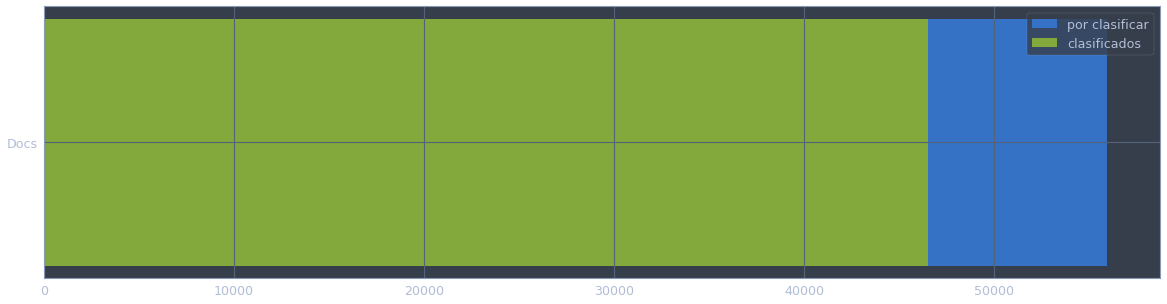

     46535


In [5]:
current_docs = collection.count_documents({"autoclassification": {"$exists": True}})
total_docs = collection.count_documents({"from.name": {"$in": ["Telenoticias", "La Nacion", 
                                                               "CR HOY", "Semanario Universidad"]}})
missing_docs = total_docs - current_docs

plt.figure(figsize=(20,5))
plt.barh(["Docs"], missing_docs, left=current_docs, label="por clasificar")
plt.barh(["Docs"], current_docs, label="clasificados")
plt.legend()
plt.show()
print("    ", current_docs)

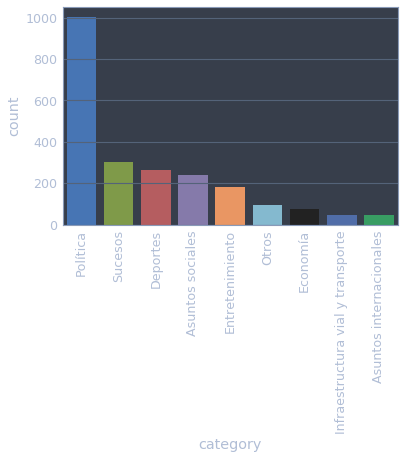

In [18]:
df = pd.DataFrame(list(collection.find({"category": {"$exists": True}})))
sns.countplot(x="category", data=df, order=df["category"].value_counts().iloc[:9].index)
plt.xticks(rotation=90)
plt.show()

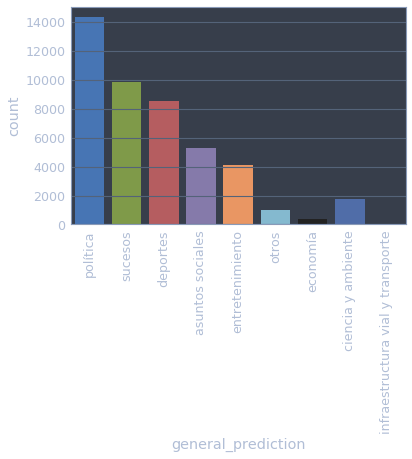

In [19]:
df2 = df
df = pd.DataFrame([x["autoclassification"] for x in 
              collection.find({"autoclassification": {"$exists": True}}, 
                              {"autoclassification.general_prediction": 1})])

sns.countplot(x="general_prediction", data=df, order=df2["category"].apply(lambda x: x.lower()).value_counts().iloc[:9].index)
plt.xticks(rotation=90)
plt.show()

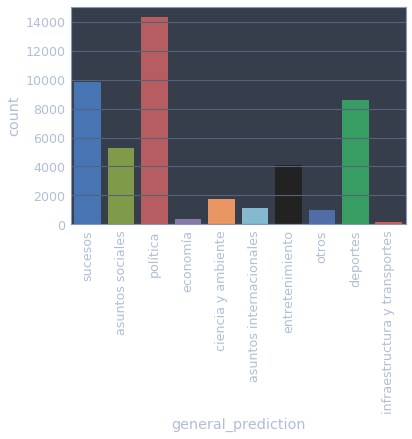

In [20]:
df = pd.DataFrame([x["autoclassification"] for x in 
              collection.find({"autoclassification": {"$exists": True}}, 
                              {"autoclassification.general_prediction": 1})])

sns.countplot(x="general_prediction", data=df)
plt.xticks(rotation=90)
plt.show()

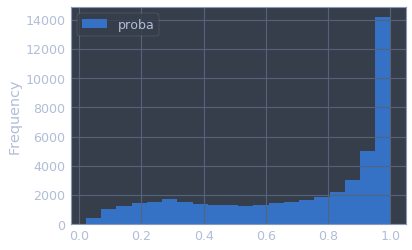

In [7]:
df = pd.DataFrame([{"proba" : x["autoclassification"]["general_proba"][x["autoclassification"]["general_prediction"]]} for x in 
              collection.find({"autoclassification": {"$exists": True}}, 
                              {"autoclassification.general_prediction": 1, "autoclassification.general_proba": 1})])
df.plot.hist(bins=20)
plt.show()

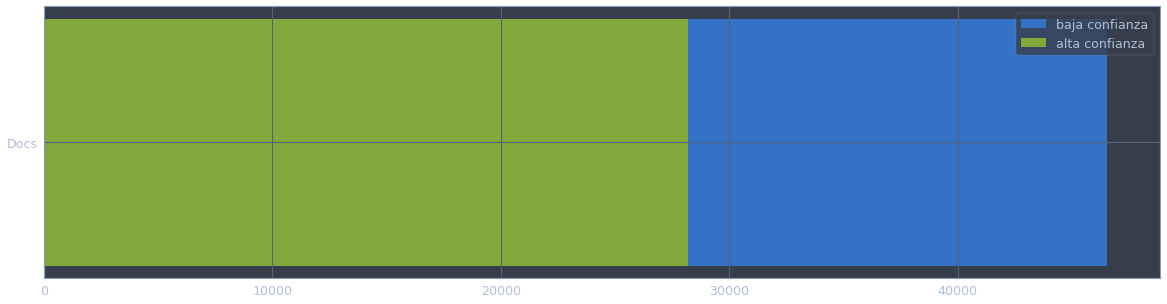

0.6055871924358011

In [8]:
ocoma7 = df[df["proba"] > 0.7].count()["proba"]
current_docs = collection.count_documents({"autoclassification": {"$exists": True}})

plt.figure(figsize=(20,5))
plt.barh(["Docs"], current_docs, label="baja confianza")
plt.barh(["Docs"], ocoma7, label="alta confianza")
plt.legend()
plt.show()

ocoma7/current_docs

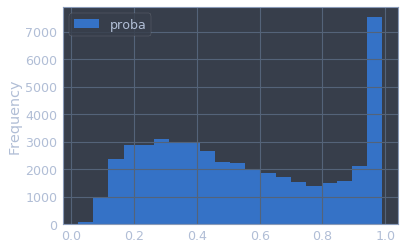

In [15]:
df = pd.DataFrame([{"proba" : x["autoclassification"]["specific_proba"][x["autoclassification"]["specific_prediction"]]} for x in 
              collection.find({"autoclassification": {"$exists": True}}, 
                              {"autoclassification.specific_prediction": 1, "autoclassification.specific_proba": 1})])
df.plot.hist(bins=20)
plt.show()

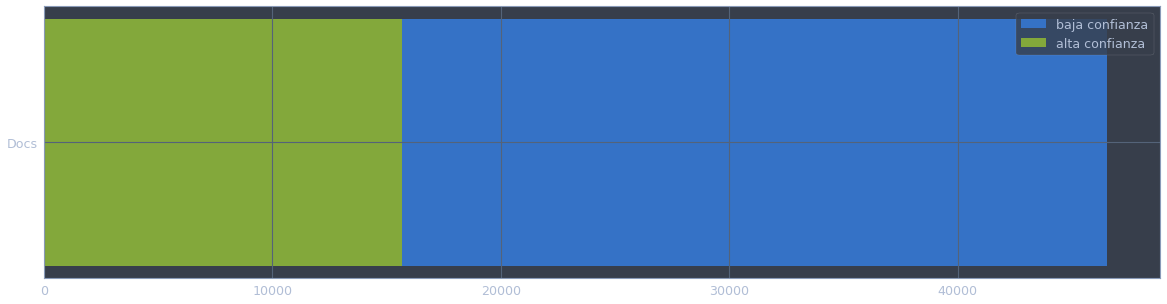

0.3365638766519824
15662


In [16]:
ocoma7 = df[df["proba"] > 0.7].count()["proba"]
current_docs = collection.count_documents({"autoclassification": {"$exists": True}})

plt.figure(figsize=(20,5))
plt.barh(["Docs"], current_docs, label="baja confianza")
plt.barh(["Docs"], ocoma7, label="alta confianza")
plt.legend()
plt.show()

print(ocoma7/current_docs)
print(ocoma7)

In [11]:
mapper = Code("""
               function () {
                   emit(this.autoclassification.specific_prediction, 1);
               }
               """)

reducer = Code("""
                function (key, values) {
                  var total = 0;
                  for (var i = 0; i < values.length; i++) {
                    total += values[i];
                  }
                  return total;
                }
                """)
dics = []
for tema in temas.TEMASG:
    docs = collection.map_reduce(mapper, reducer, "myresults", 
                                 query={"autoclassification": {"$exists": True}, 
                                        "autoclassification.general_prediction" : tema})
    mx = -1
    best = None
    sm = 0
    for doc in docs.find({}):
        sm += doc["value"]
        if mx < doc["value"]:
            mx = doc["value"]
            best = doc["_id"]
            
    res = {"Tema": tema, "Tema Especifico": best, "Cantidad": mx, "Total": sm, "Porcentaje": mx/sm}
    dics.append(res)

df = pd.DataFrame(dics)[["Tema", "Tema Especifico", "Cantidad", "Total", "Porcentaje"]]
df

,Tema,Tema Especifico,Cantidad,Total,Porcentaje
0,sucesos,accidente,4851.0,9832.0,0.493389
1,infraestructura y transportes,infraestructura vial,93.0,194.0,0.479381
2,entretenimiento,farandula,2254.0,4122.0,0.546822
3,política,gobierno,5619.0,14321.0,0.392361
4,deportes,futbol,8434.0,8566.0,0.984590
5,ciencia y ambiente,tecnologia,876.0,1763.0,0.496880
6,asuntos internacionales,nicaragua,983.0,1109.0,0.886384
7,otros,curiosidades,966.0,980.0,0.985714
8,economía,negocios,244.0,360.0,0.677778
9,asuntos sociales,salud,3239.0,5288.0,0.612519


In [12]:
for tema in temas.TEMASG:
    docs = db.command("aggregate", "posts", pipeline=[ {"$match" : {"autoclassification": 
                                                                    {"$exists": True}, 
                                                                    "autoclassification.general_prediction" : tema}
                                                       }, {
                                                        "$sample": {"size": 3}
                                                        }
                                                     ])
    len(docs["result"])
    printmd("# " + tema)
    for idx, doc in enumerate(docs["result"]):
        printmd("### Noticia " + str(idx + 1))
        printmd("**" + doc["post_message"] + "**")
        ac = doc["autoclassification"]
        printmd(ac["specific_prediction"])
        print(doc["link"])
        printmd("Confianza general: %.02f, Confianza específica: %.02f" % (ac["general_proba"][ac["general_prediction"]], ac["specific_proba"][ac["specific_prediction"]]))

# sucesos

### Noticia 1

**Cruzar lejos de las esquinas o semforos   tirarse  entre vehculos y no fijarse a ambos lados de la calle  son errores que hacen a los peatones.**

accidente

https://www.teletica.com/197752_sabe-cuales-errores-frecuentes-de-los-peatones-provocan-accidentes


Confianza general: 0.59, Confianza específica: 0.23

### Noticia 2

**El choque dej 2 heridos  uno de ellos en condicin delicada**

accidente

https://www.crhoy.com/nacionales/dos-heridos-tras-choque-de-carros-y-moto-en-alajuela/


Confianza general: 0.97, Confianza específica: 0.78

### Noticia 3

**La Fiscala del I Circuito Judicial de San Jos  abri una causa a la conductora que esta maana golpe a al menos tres manifestantes  en las cercanas del Tribunal Supremo de Elecciones (TSE)  en la capital.**

accidente

https://trib.al/FEhhOtP


Confianza general: 0.97, Confianza específica: 0.11

# infraestructura y transportes

### Noticia 1

**Desde el 2014 la empresa Globalva propuso ampliar en seis carriles la ruta 27  desde la Sabana hasta Ciudad Coln y en cuatro carriles el tramo de Ciudad Coln a Orotina.**

infraestructura vial

https://trib.al/4YzyGBp


Confianza general: 0.99, Confianza específica: 0.63

### Noticia 2

**Uber responde al Gobierno y asegura que sus ms de 22.000 colaboradores no pueden dejar de recibir sus ingresos mientras se mantienen a la espera de que se aplique un marco regulatorio  adems  invitan al Gobierno a escuchar los diferentes actores para regular el servicio.**

uber

https://www.teletica.com/203637_uber-mas-de-22000-trabajadores-no-pueden-dejar-de-recibir-ingresos-mientras-se-emita-regulacion


Confianza general: 0.91, Confianza específica: 0.79

### Noticia 3

**De nuestro blog #CrnicasDeLosMercados**

uber

https://trib.al/ojexKnj


Confianza general: 0.90, Confianza específica: 0.78

# entretenimiento

### Noticia 1

**Entretenimiento: Al parecer  el artista no quiere hacerse responsable**

farandula

https://www.crhoy.com/entretenimiento/exactriz-porno-habria-tenido-un-hijo-del-rapero-drake/


Confianza general: 0.94, Confianza específica: 0.53

### Noticia 2

**Al centro de un escndalo presidencial: Monica Lewinsky (izq)  en los 1990 y Stormy Daniels (der)  actualmente.**

farandula

https://www.teletica.com/195359_monica-lewinsky-y-stormy-daniels-dos-escandalos-politicos-ocurridos-en-dos-eras-distintas


Confianza general: 0.36, Confianza específica: 0.51

### Noticia 3

**La pelcula costarricense Violeta al fin  de la directora Hilda Hidalgo fue comprada por el canal de paga estadounidense.**

farandula

https://trib.al/hU2nzjx


Confianza general: 0.64, Confianza específica: 0.20

# política

### Noticia 1

**Sobre si se puede tramitar con la va rpida y otras dudas.**

huelga

https://www.crhoy.com/nacionales/gremios-judiciales-piden-a-corte-pronunciarse-sobre-tramite-de-plan-fiscal/


Confianza general: 0.97, Confianza específica: 0.10

### Noticia 2

**Isabel Porras renunci este martes a su cargo aduciendo razones personales.**

gobierno

http://ow.ly/911D30lRZJF


Confianza general: 0.87, Confianza específica: 0.48

### Noticia 3

**El presidente electo de Mxico anunci la esperada designacin de los jefes de la Defensa Nacional y de la Marina. Los nombramientos son clave para la estrategia de  pacificacin .**

gobierno

http://ow.ly/sTLe30mmqzk


Confianza general: 0.19, Confianza específica: 0.32

# deportes

### Noticia 1

**El volante nacional fue convocado para el partido de este mircoles contra el Cear**

futbol

https://www.crhoy.com/deportes/bryan-ruiz-debutara-este-miercoles-con-la-camiseta-del-santos/


Confianza general: 0.98, Confianza específica: 0.96

### Noticia 2

**El jugador escocs  de 30 aos  salt al campo con el dispositivo en el inicio de la temporada de la Liga Premier de su pas tras librarse el mes pasado de ir a prisin**

futbol

https://goo.gl/BC7pZ3


Confianza general: 0.49, Confianza específica: 0.95

### Noticia 3

**El ttulo 30 no llegar esta vez a las vitrinas manudas**

futbol

https://www.crhoy.com/deportes/el-30-no-llegara-pero-los-memes-si/


Confianza general: 0.99, Confianza específica: 0.97

# ciencia y ambiente

### Noticia 1

**Cartago  San Jos y Heredia seran los sitios donde se estn presentando las precipitaciones a causa de la onda tropical 24.**

clima

http://ow.ly/AlXM30ljcVC


Confianza general: 0.78, Confianza específica: 0.52

### Noticia 2

**La riqueza natural de nuestro pas no tiene lmites cuando de turismo  aventura y relajacin se trata. Y usted ya visit alguno de los 10 rincones que describe la prensa espaola?**

ambiente

http://ow.ly/8Poa30lW1Qi


Confianza general: 1.00, Confianza específica: 0.45

### Noticia 3

**Por su parte los vientos tendrn una velocidad que oscilara entre los 30 kilmetros y 60 kilmetros por hora  esto ocasionar pocas lluvias.**

animales

https://www.teletica.com/198712_olas-de-mas-de-dos-y-tres-metros-se-esperan-para-este-domingo-en-las-playas-del-pacifico-y-caribe


Confianza general: 0.81, Confianza específica: 0.17

# asuntos internacionales

### Noticia 1

**Estas son algunas historias de cmo fueron detenidas estas personas por protestar en Nicaragua**

nicaragua

https://trib.al/fZgZS50


Confianza general: 0.98, Confianza específica: 0.86

### Noticia 2

**Entrevista con el expresidente de la Repblica scar Arias Snchez. Por qu se ha echado tanta gente encima Daniel Ortega?  se le pregunta.**

nicaragua

https://trib.al/tjVayns


Confianza general: 0.99, Confianza específica: 0.88

### Noticia 3

**La intencin es  retomar nuevamente las calles para mantener viva la lucha cvica y reclamar nuestro derecho de protesta pacfica   seal la oposicin de Nicaragua.**

nicaragua

https://trib.al/ZK2MObK


Confianza general: 1.00, Confianza específica: 0.80

# otros

### Noticia 1

**El patlogo forense Richard Shepherd ha investigado algunas de las grandes tragedias de los ltimos aos.**

curiosidades

https://www.teletica.com/205324_el-hombre-que-ha-realizado-23000-autopsias


Confianza general: 0.76, Confianza específica: 0.44

### Noticia 2

**Algunas mujeres con grises naturales estn abandonando los tintes. Qu est cambiando? es usted una de ellas o an utiliza tintes para disimular sus canas?**

curiosidades

https://www.teletica.com/199841_mi-mama-me-vio-mi-primera-cana-a-los-7-anos-mas-mujeres-jovenes-deciden-lucir-pelo-gris-natural


Confianza general: 0.70, Confianza específica: 0.68

### Noticia 3

**Entretenimiento: La hermana de la duquesa le dej una carta**

curiosidades

https://www.crhoy.com/mundo/desalojan-a-hermana-de-meghan-markle-de-palacio-de-kensington/


Confianza general: 0.79, Confianza específica: 0.68

# economía

### Noticia 1

**Al ao  en promedio  1.200 personas refugiadas se insertan en el mbito laboral de Costa Rica  segn datos de Acnur. Cmo lo logran? Conozca dos de las historias:**

trabajo

https://trib.al/VuXEw6i


Confianza general: 0.54, Confianza específica: 0.49

### Noticia 2

**No trascendi el monto que Walmart pagar por la cadena de supermercados costarricense.**

negocios

https://www.teletica.com/199744_walmart-acuerda-la-compra-de-perimercados-super-compro-y-saretto


Confianza general: 1.00, Confianza específica: 0.66

### Noticia 3

**En esta nota le contamos en cules reas hay plazas disponibles y fecha y lugar de la feria.**

trabajo

http://ow.ly/PIHl30kFOgE


Confianza general: 1.00, Confianza específica: 0.82

# asuntos sociales

### Noticia 1

**El pequeo necesita una silla de ruedas especial pero a sus paps les es difcil comprarla.**

salud

https://www.teletica.com/200973_joven-pareja-lucha-para-sacar-adelante-a-su-hijo-quien-padece-una-extrana-enfermedad


Confianza general: 0.38, Confianza específica: 0.88

### Noticia 2

**Cardiloga que hizo denuncia en 2015 sostiene que al menos 125 de los 141 fallecidos que aguardaban procedimiento murieron por fallos cardacos.**

salud

https://trib.al/80LhKpw


Confianza general: 0.86, Confianza específica: 0.89

### Noticia 3

**dgar Mora pidi a los diputados que permitan que los fondos que tiene los maestros en la Junta de Pensiones del Magisterio Nacional financien la construccin de escuelas y colegios que llevan 30 aos de rezago.**

educacion

https://trib.al/24RPiqk


Confianza general: 0.67, Confianza específica: 0.96

In [35]:
docs = db.command("aggregate", "posts", pipeline=[ {"$match" : {"autoclassification": 
                                                                {"$exists": True}}
                                                   }, {
                                                    "$sample": {"size": 400}
                                                    }
                                                 ])

l = [{"id":x["_id"], "Texto en FB" : x["post_message"], "Link": x["link"], 
  "Tema General": x["autoclassification"]["general_prediction"],
  "Tema Específico": x["autoclassification"]["specific_prediction"], "Correcto/Incorrecto": ""} for x in docs["result"]]

df = pd.DataFrame(l)[["id", "Texto en FB", "Link", "Tema General", "Tema Específico", "Correcto/Incorrecto"]]
df.head()

df.to_excel("experimento.xls")